# Lesson 8 - Object detection

https://course.fast.ai/part2.html
Uses Pascal 2007 VOC dataset

last edit: 12/1/18


In [46]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [47]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# Input data files are available in the "../input/" directory - 
# input is READ-ONLY
import os
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [48]:
# assert torch.cuda.is_available()
# assert torch.backends.cudnn.enabled

INPUT_PATH = "../input/"
TMP_PATH = "/kaggle/working/tmp/"
MODEL_PATH = "/kaggle/working/models/"
FILE_NAME = 'file_name'
ID = 'id'
IMG_ID = 'image_id'
CAT_ID = 'category_id'
BBOX = 'bbox'
NAME = 'name'
JPEGS = 'voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages'

In [49]:
#print(os.listdir("../input/pascal_voc"))
INPUT_PATH = Path(INPUT_PATH)
paths=list(INPUT_PATH.iterdir())
#print(paths)
#!ls {paths[0]}/VOCdevkit/VOC2007
IMG_PATH = INPUT_PATH/JPEGS
assert os.path.isdir(IMG_PATH)
META = Path(INPUT_PATH/'pascal_voc'/'PASCAL_VOC')
assert os.path.isdir(META)
# metadata is in json file
# train
trn_j = json.load((META/'pascal_train2007.json').open())
# test
test_j = json.load((META/'pascal_test2007.json').open())
# validation
test_j = json.load((META/'pascal_val2007.json').open())
#print(trn_j.keys())
for k in trn_j.keys():
    print(len(trn_j[k]), k)
# annotations are bounding boxes showing where each object is. These were hand labeled.
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']

2501 images
9 type
7844 annotations
20 categories


In [50]:
#print("type", trn_j["type"])
#print([(c["id"], c["name"]) for c in  trn_j[CATEGORIES]])
print("1st 5 images: 000012.jpg, 000017.jpg, 000023.jpg, 000026.jpg, 000032.jpg")
print(trn_j[IMAGES][:5])
# first image
id0 = trn_j[IMAGES][0][ID]
# and it's annotation
ann0 = [next(x for x in trn_j[ANNOTATIONS] if x[IMG_ID] == id0)][0]
print(ann0)

1st 5 images: 000012.jpg, 000017.jpg, 000023.jpg, 000026.jpg, 000032.jpg
[{'file_name': '000012.jpg', 'height': 333, 'width': 500, 'id': 12}, {'file_name': '000017.jpg', 'height': 364, 'width': 480, 'id': 17}, {'file_name': '000023.jpg', 'height': 500, 'width': 334, 'id': 23}, {'file_name': '000026.jpg', 'height': 333, 'width': 500, 'id': 26}, {'file_name': '000032.jpg', 'height': 281, 'width': 500, 'id': 32}]
{'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]], 'area': 34104, 'iscrowd': 0, 'image_id': 12, 'bbox': [155, 96, 196, 174], 'category_id': 7, 'id': 1, 'ignore': 0}


In [51]:
# categories
cats = {o[ID]:o[NAME] for o in trn_j[CATEGORIES]}
# map image-id: file name
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [52]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME], im0_d[ID]

('000012.jpg', 12)

In [53]:
def hw_bb(bb): 
    """
    convert VOC's height/width into top-left/bottom-right, 
    and switch x/y coords to be consistent with numpy.
    """
    return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

def bb_hw(a):
    """converts bounding box to height and width"""
    return np.array([a[1], a[0], a[3]-a[1]+1, a[2]-a[0]+1])

def show_img(im, figsize=None, ax=None):
    if not ax: 
        fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

def draw_im(im, ann):
    """
    draw image with annotated bounding boxes
    """
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)
        
def draw_idx(i):
    """
    draw annotated image at index i 
    """
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)        

In [54]:
trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
len(trn_anno)  

2501

(364, 480, 3)


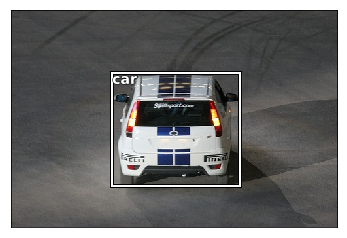

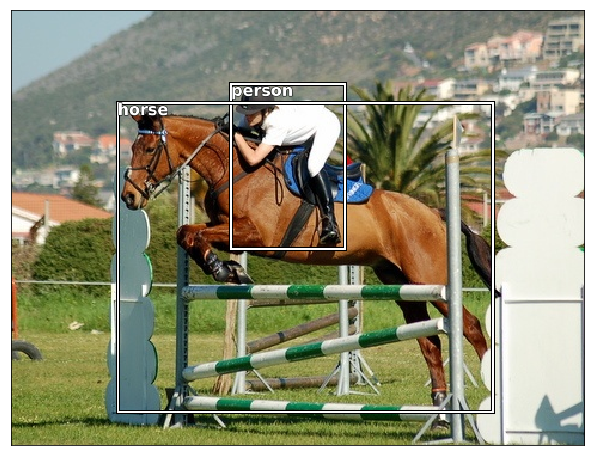

In [55]:
im0_d = trn_j[IMAGES][0]
im_a= trn_anno[im0_d[ID]]
im0_a = im_a[0]

im = open_image(IMG_PATH/im0_d[FILE_NAME])
ax = show_img(im)
#print(im0_a[0])
# bounding box
b = bb_hw(im0_a[0])
#print(b)
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])
draw_idx(17)

# Step 1 - Classify and localize largest object in each image

In [56]:
def get_lrg(b):
    """
        image with largest area
    """
    if len(b) == 0: return
    b = sorted(b, key = lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]
# map - image id : largest bb for the image (dictionary comprehension)
trn_lrg_anno = {a: get_lrg(b) for a, b in trn_anno.items()}

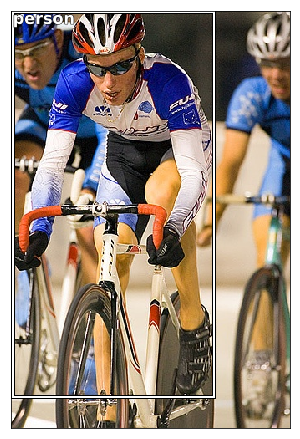

In [57]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

# Create CSV file with data we need using Pandas

In [58]:
if not os.path.isdir(TMP_PATH): 
    os.mkdir(TMP_PATH)
CSV = Path(TMP_PATH+"/lrg.csv")

In [59]:
df = pd.DataFrame({'fn': [ trn_fns[o] for o in trn_ids],
                  'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]},
                          columns=['fn', 'cat'])
df.to_csv(CSV, index=False)
!ls -ltrh {TMP_PATH}

total 112K
-rw-r--r-- 1 root root 63K Dec  1 21:17 bb.csv
-rw-r--r-- 1 root root 43K Dec  1 22:11 lrg.csv


In [60]:
f_model = resnet34
sz = 224
bs = 64

In [61]:
# transform
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
# model data
md = ImageClassifierData.from_csv(INPUT_PATH, JPEGS, CSV, tfms=tfms, bs=bs)

In [62]:
# grab 1 minibatch
x,y = next(iter(md.val_dl))

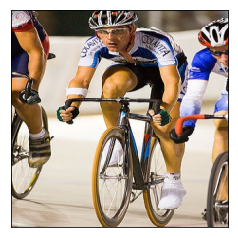

In [63]:
show_img(md.val_ds.denorm(to_np(x))[0]);

In [64]:
# learner
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy], tmp_name=TMP_PATH, models_name=MODEL_PATH)

/opt/conda/lib/python3.6/site-packages/fastai/initializers.py:6: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  if hasattr(m, 'weight'): init_fn(m.weight)


In [65]:
# optimizer 
learn.opt_fn = optim.Adam
lrf = learn.lr_find(1e-5, 100)

 78%|███████▊  | 25/32 [00:18<00:03,  2.04it/s, loss=12]  

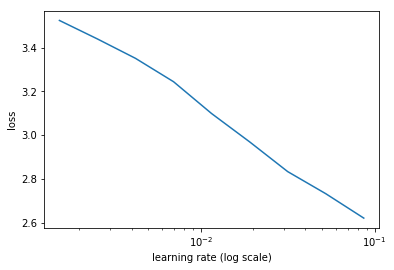

In [66]:
learn.sched.plot()

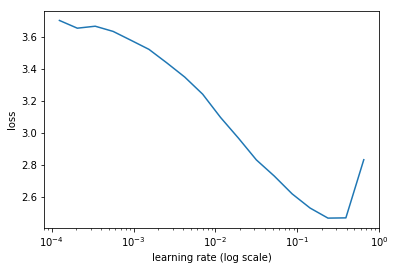

In [67]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [68]:
lr = 2e-2

In [69]:
# TRAIN
learn.fit(lr, n_cycle=1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.269737   0.702399   0.794     


[0.7023993773460389, 0.7940000009536743]

In [70]:
lrs = np.array([lr/1000, lr/100, lr])
learn.freeze_to(-2)
lrf=learn.lr_find(lrs/1000)

 84%|████████▍ | 27/32 [00:25<00:02,  1.78it/s, loss=3.7]  

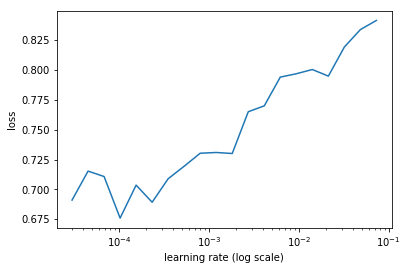

In [71]:
learn.sched.plot(1)

In [72]:
learn.fit(lrs/5, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.833287   0.606252   0.816     


[0.6062517337799073, 0.8160000038146973]

In [73]:
learn.unfreeze()

In [74]:
learn.fit(lrs/5, 1, cycle_len=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.672479   0.566709   0.826     
    1      0.471326   0.579786   0.822                     


[0.5797863957881928, 0.8220000023841858]

In [75]:
learn.save("l8")

In [76]:
learn.load("l8")

In [77]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x, preds = to_np(x), to_np(probs)
preds = np.argmax(preds, -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


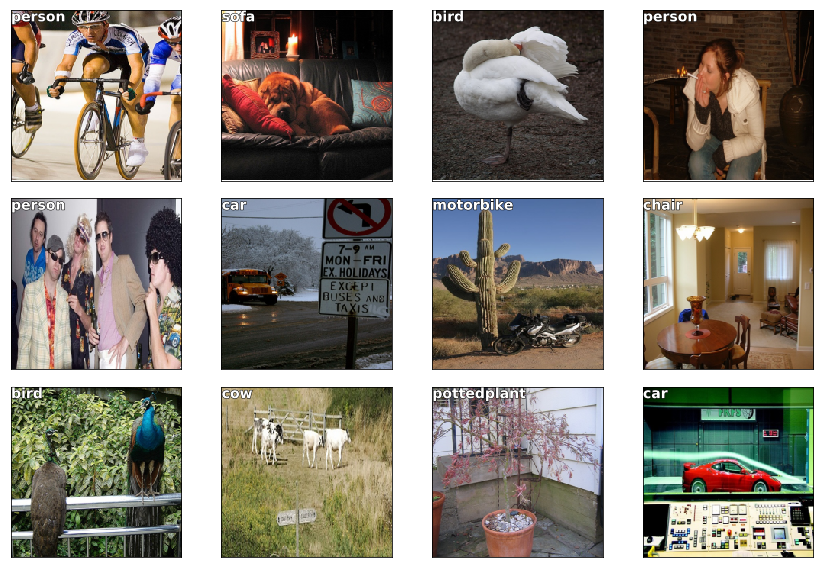

In [78]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    #pdb.set_trace()
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()    

In [79]:
# finding bboxes
BB_CSV = Path(TMP_PATH + '/bb.csv')
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids] )
bbs = [' '.join(str(p) for p in o) for o in bb]
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs},
                  columns=['fn', 'bbox'])
df.to_csv(BB_CSV, index=False)

In [80]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [81]:
f_model = resnet34
sz = 226
bs = 64

In [82]:
augs = [RandomFlip(), RandomRotate(30), RandomLighting(0.1, 0.1)]

In [83]:
# transform
tfms = tfms_from_model(f_model, sz, aug_tfms=augs, crop_type=CropType.NO)
# model data
md = ImageClassifierData.from_csv(INPUT_PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=bs)

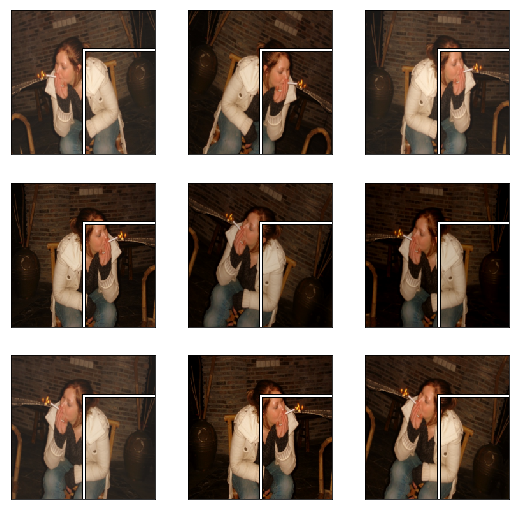

In [84]:
idx = 3
fig, axes = plt.subplots(3,3,figsize=(9,9))
for i, ax in enumerate(axes.flat):
    x, y = next(iter(md.aug_dl))
    ima = md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    #print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)